# Exploratory Data Analysis

In [195]:
import logging
import mmap
import h5py
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import matplotlib as pyplt
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from joblib import Parallel, delayed
import plotly.figure_factory as ff

## 1. Extracting data
 (_Using modified code from RICHPID, Original author: Bob_)

In [2]:
logger = logging.getLogger(__name__)

In [3]:
def compute_seq_id(hit, or_id=0):
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id)

In [4]:
# Original Author: Bob ; modified for adding labels (ref: notebooks/input_data)
class RICHDataset(Dataset):
    """RICH pytorch dataset."""

    def check_dataset(self, name, obj):
        """ "Check the input file fromat."""
        if isinstance(obj, h5py.Dataset):
            print(name, obj.shape)
            print(name, obj.chunks)
            print(name, obj.compression)
            print(name, obj.dtype)
            # raise BadDataFormat('Unexpected data format, check the logs.')

    def __init__(
        self, dset_path, val_split, test_split, return_type="tensor", seed=None
    ):

        self.return_type = return_type

        if seed:
            np.random.seed(seed)

        # We don't attempt to catch exception here, crash if we cannot open the file.
        with h5py.File(dset_path, "r") as dfile:

            for key in dfile.attrs:
                logger.info("%s: %s", key, dfile.attrs[key])

            # We don't attempt to catch exception here,
            # crash if the data format is not what we were expecting.
            dfile.visititems(self.check_dataset)

            # Load the hit map into memory
            self.hit_mapping = np.asarray(dfile["HitMapping"][:])
            logger.info("hit map size: %i bytes", self.hit_mapping.nbytes)
            self.N = len(self.hit_mapping) - 1  # !!! The last cell is the sentinel !!!

            # Get the info we need to memory map the hits
            hit_ds = dfile["Hits"]
            hit_offset = hit_ds.id.get_offset()
            hit_dtype = hit_ds.dtype
            hit_shape = hit_ds.shape
            hit_length = np.prod(hit_shape)

            # Get the info we need to memory map the events
            event_ds = dfile["Events"]
            event_offset = event_ds.id.get_offset()
            event_dtype = event_ds.dtype
            event_shape = event_ds.shape
            event_length = np.prod(event_shape)

            # Add labels
            mu_off = dfile.attrs["muon_offset"]
            pi_off = dfile.attrs["pion_offset"]
            pos_off = dfile.attrs["positron_offset"]
            entries = dfile.attrs["entries"]

            # muon: 0, pion: 1, positron: 2
            self.labels = np.zeros(entries, dtype=np.int32)
            self.labels[mu_off:pi_off] = 0
            self.labels[pi_off:pos_off] = 1
            self.labels[pos_off:] = 2

            logger.info(f'Entries: {entries}')
            logger.info(f'Muons start at index: {mu_off}')
            logger.info(f'Pions start at index: {pi_off}')
            logger.info(f'Positron start at index: {pos_off}')

            # train test indices
            indices = np.arange(len(self))
            n_val = int(len(indices) * val_split)
            n_test = int(len(indices) * test_split)
            self.train_indices = indices[: -n_val - n_test]
            self.val_indices = indices[-n_test - n_val : -n_test]
            self.test_indices = indices[-n_test:]

        # We don't attempt to catch exception here, crash if we cannot open the file.
        with open(dset_path, "rb") as fh:
            fileno = fh.fileno()
            mapping = mmap.mmap(fileno, 0, access=mmap.ACCESS_READ)
            self.hit_array = np.frombuffer(
                mapping, dtype=hit_dtype, count=hit_length, offset=hit_offset
            ).reshape(hit_shape)
            logger.info("hit array mmap size: %i bytes", self.hit_array.nbytes)
            self.event_array = np.frombuffer(
                mapping, dtype=event_dtype, count=event_length, offset=event_offset
            ).reshape(event_shape)
            logger.info("event array mmap size: %i bytes", self.event_array.nbytes)

    def get_position_data(self):
        return np.load(os.path.join("../tools", "rich_pmt_positions.npy"))

    def get_event_pos(self, idx):

        # get hits
        idx_from = self.hit_mapping[idx]
        idx_to = self.hit_mapping[idx + 1]
        hits = self.hit_array[idx_from:idx_to]

        # load position map data
        position_map = self.get_position_data()

        # create index
        index = compute_seq_id(hits)
        event_pos = position_map[index]

        return event_pos

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise NotImplementedError(f"{type(idx)} type key access is not implemented")
        if idx < 0:
            raise NotImplementedError("negative index access is not implemented")

        idx_from = self.hit_mapping[idx]
        idx_to = self.hit_mapping[idx + 1]

        # prepare data
        event_pos = self.get_event_pos(idx)
        labels = self.labels[idx]
        hit_time = self.hit_array[idx_from:idx_to]["hit_time"]
        chod_time = self.event_array[idx]["chod_time"]
        track_momentum = self.event_array[idx]["track_momentum"]
        ring_radius = self.event_array[idx]["ring_radius"]

        if self.return_type == "numpy":
            return {
                "event_pos": event_pos,
                "label": labels,
                "hit_time": hit_time,
                "chod_time": chod_time,
                "track_momentum": track_momentum,
                "ring_radius": ring_radius,
            }
        elif self.return_type == "tensor":
            return {
                "event_pos": torch.tensor(event_pos),
                "label": torch.tensor(labels),
                "hit_time": torch.tensor(hit_time),
                "chod_time": torch.tensor(chod_time),
                "track_momentum": torch.tensor(track_momentum),
                "ring_radius": torch.tensor(ring_radius),
            }


In [11]:
# Reading in data from /data/bvelghe/capstone2022/A/ using dataloader RICHDataset
dset_path = "/data/bvelghe/capstone2022/A/Run008548.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01.h5"
dset = RICHDataset(
    dset_path,
    val_split=0.1, 
    test_split=0.1, 
    return_type="tensor"
)

Events (128982,)
Events None
Events None
Events {'names': ['run_id', 'burst_id', 'event_id', 'track_id', 'track_momentum', 'chod_time', 'ring_radius', 'ring_centre_pos', 'ring_likelihood'], 'formats': ['<i4', '<i4', '<i8', '<i4', '<f4', '<f4', '<f4', ('<f4', (2,)), ('<f4', (3,))], 'offsets': [0, 4, 8, 16, 20, 24, 28, 32, 40], 'itemsize': 56}
HitMapping (128983,)
HitMapping (128982,)
HitMapping gzip
HitMapping int64
Hits (4689741,)
Hits None
Hits None
Hits [('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')]


## 2. Fetching offsets (This needs to be built into RICHDataset class)

In [12]:
# Reading in the raw data hdf5 file
dfile = h5py.File(dset_path, 'r')

In [13]:
# offsets
mu_off = dfile.attrs["muon_offset"]
pi_off = dfile.attrs["pion_offset"]
pos_off = dfile.attrs["positron_offset"]
entries = dfile.attrs["entries"]

In [14]:
# Reading in delta for 1 event
ht_muon = dset[0]['hit_time'] - dset[0]['chod_time']
ht_muon

tensor([ 1.1471e-01, -4.3059e-02, -3.4746e-01, -1.2931e-01,  6.6697e-02,
        -1.0588e-01, -3.4516e+01, -4.6711e-02, -7.9382e-02, -2.0903e-01,
        -1.9880e-01, -1.1443e-02,  9.8967e-01,  1.4476e+00,  8.5365e-01,
        -3.4213e+01, -1.5865e-01, -6.1951e-01, -6.4682e-02,  2.8284e-02,
        -6.6747e-01, -6.9758e-01])

## 3. EDA Objectives 

### 3.1 How close to 0 should be the Hit times - Chod time (delta) for the events ? An attempt at finding the ideal cut-off

(We understand that pointnet/ GCNN, may be able to handle this implicitly)

From https://github.com/TRIUMF-Capstone2022/RICHPID/blob/main/docs/slides/intro_data_apr8_v0.pdf, 
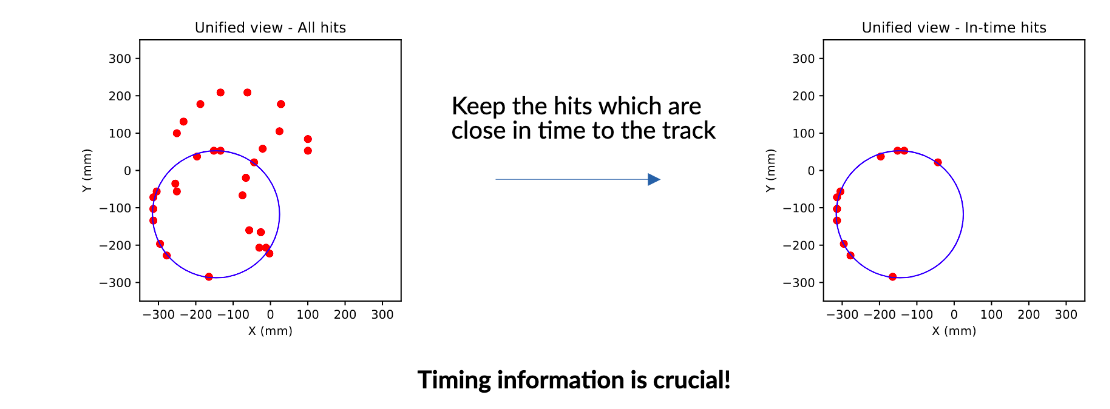

## Exploring Delta

### 3.1 Plotting densities (method - kde) for delta (mean hit_time~chod_time) with Different smoothing parameters

***Low bandwidth (sd of the smoothing kernel) *** : 
We observe bimodal densities at low bandwidths

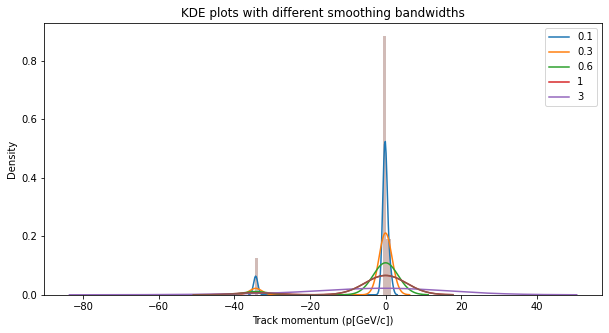

In [196]:
plt.figure(figsize=(10, 5))
fig = sns.kdeplot(ht_muon, bw_adjust=0.1, label = "0.1")
fig = sns.kdeplot(ht_muon, bw_adjust=0.3, label = "0.3")
fig = sns.kdeplot(ht_muon, bw_adjust=0.6, label = "0.6")
fig = sns.kdeplot(ht_muon, bw_adjust=1, label = "1")
fig = sns.kdeplot(ht_muon, bw_adjust=3, label = "3")
fig = sns.distplot(ht_muon)
plt.legend()
plt.title("KDE plots with different smoothing bandwidths")
plt.xlabel("Delta: Hit time ~ Chod time ()")
plt.show()

***High smoothing values***: We observe densities now centered around 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


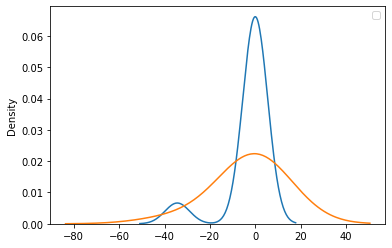

In [182]:
fig = sns.kdeplot(ht_muon, bw_adjust=1, label = "muon")
fig = sns.kdeplot(ht_muon, bw_adjust=3)
plt.legend()
plt.show()

### Plotting for Sub-sampled muon events

#### 1000 Events

In [80]:
# Sample size
n = 1000

In [17]:
# Defining function for delta
def delta(i):
    return (dset[i]['hit_time'] - dset[i]['chod_time']).numpy().mean()

In [77]:
# Defining function for randomly sampling indices
def get_idx(n, offset, seed=123):
    """Returns randomly sampled list of indices"""
    np.random.seed(seed)
    idx_start = offset
    idx_end = offset + n

    idx_list = np.random.choice(
        range(idx_start, idx_end),
        n, 
        replace = False
    )
    return idx_list

In [92]:
# Getting n indices from muon events
idx_list_muon_n = get_idx(n, mu_off)

In [122]:
delta_muon_A = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_muon_n)

<AxesSubplot:ylabel='Density'>

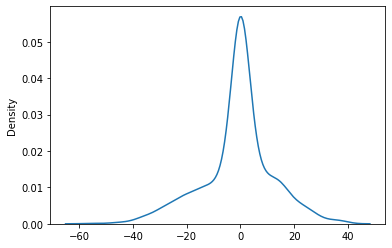

In [123]:
# Plotting delta for 1000 muon events
sns.kdeplot(delta_muon_A)

## 4. Plotting for momentum

### 4.1 Muon events

In [51]:
# Defining function for momentum
def momentum(i):
    return (dset[i]['track_momentum'].numpy())

In [126]:
# Parallelising (currently for 1000 muon events)
p_muon_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_muon_n)

<AxesSubplot:ylabel='Density'>

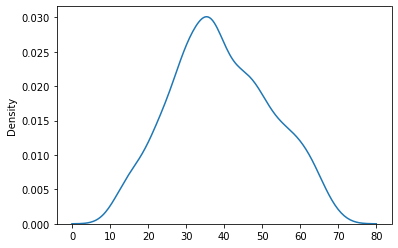

In [127]:
# Plotting momentum for 1000 muon events
sns.kdeplot(np.asarray(p_muon_A))

### 4.2 Pion Events

In [128]:
# Getting indexes 
idx_list_pion_n = get_idx(n, pi_off)[:-1]  # Removing the sentinel value

In [129]:
# Parallelising for 1000 pion events
p_pion_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_pion_n)

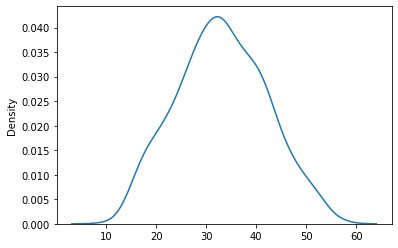

In [130]:
# Plotting momentum for 1000 muon events
sns.kdeplot(np.asarray(p_pion_A))

### 4.3 Positron events

In [131]:
# Getting indexes 
idx_list_pos_n = get_idx(n, pos_off)

In [133]:
# Parallelising 
p_pos_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_pos_n)

### 4.4 Overlay of momentum density plots all three particles for n = 1000 each

In [177]:


# Add histogram data
sample_muon = np.asarray(p_muon_A)
sample_pion = np.asarray(p_pion_A)
sample_positron = np.asarray(p_pos_A)

# Group data together
hist_data = [sample_muon, sample_pion, sample_positron]
group_labels = ['muon', 'pion', 'positron']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=[2,4,5,10], curve_type="normal")
fig.update_layout(
    title_text=f'Distplots of sampled particles (n = {n}) with Normal Distribution',
    
)
fig.show()

### Momentum Bins

what to do with momentum bins?

From the ring radius ~ track momentum plot, it is expected that the particles are 
 - fairly separable in lower momentum bins, 
 - less separable in medium, and 
 - almost inseparable in higher momentum bins. 
 
So, if the model learns that the momentum values are important for the classification, it may be biased towards particle momentum, or in other words, it will give higher weights to momentum while training. 

In order to find out if , there are two important questions to be answered:
1. What should be our signficance level?
For the pion classifier, alpha ~ 0.001 

2. From what momentum value onwards, do the the particles become statistically inseparable at alpha significance level?